In [46]:
# Import libraries
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import random

In [47]:
def df_to_db(df,database_file,table_name):
  conn = sqlite3.connect(database_file)
  df.to_sql(table_name, conn, if_exists='replace')
  conn.close()

def get_data(base_url,endpoint):
  url = f"{base_url}/{endpoint}"
  response = requests.get(url)
  return response.json()

def create_database(database_file):
  # Connect to the database (creates the file if it doesn't exist)
  conn = sqlite3.connect(database_file)

  # Close the connection (optional, but good practice)
  conn.close()

def id_to_name(x,df,name_col:str="player_name"):
  return df.query("entry == @x")[name_col].values[0]

def plot_timeseries(df,team_data_df):
  fig = go.Figure()
  for col in df:
    fig.add_trace(go.Scatter(
      y=df[col],
      name=id_to_name(col,team_data_df)
    ))
  fig.show()

def generate_hex_color(num_colors):
  """
  Generates a list of random hexadecimal color codes.

  Args:
    num_colors: The number of colors to generate.

  Returns:
    A list of hexadecimal color codes (strings).
  """
  color_list = []
  for _ in range(num_colors):
    hex_code = "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
    color_list.append(hex_code)
  return color_list

def plot_timeseries_bar_by_gw(df:pd.DataFrame,colour_dict:dict,team_data_df):
  df = df.copy()
  df.columns = [id_to_name(col,team_data_df) for col in df.columns]
  df = df.T

  # Create figure
  fig = go.Figure()

  # Add traces, one for each slider step
  for i in df.columns:
    fig.add_trace(
      go.Bar(
        visible=False,
        x=df[i].sort_values(),
        y=df[i].sort_values().index,
        orientation='h',
        marker_color=[colour_dict[y] for y in df[i].sort_values().index]
        ))

  # Make first trace visible
  fig.data[0].visible = True

  # Create and add slider
  steps = []
  for i in range(len(fig.data)):
    step = dict(
      method="update",
      args=[{"visible": [False] * len(fig.data)},
      {"title": "Total by week: " + str(i+1)}],  # layout attribute
      )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

  sliders = [dict(
    active=0,
    currentvalue={"prefix": "GW: "},
    pad={"t": 50},
    steps=steps
  )]

  fig.update_layout(
    sliders=sliders
  )

  fig.show()

def get_timeseries(data,prop):
  df = pd.DataFrame()
  for id in data.keys():
    df[id] = [data[id]["current"][i][prop] for i in range(len(data[id]["current"]))]
  df["gw"] = list(range(1,len(df)+1))
  df = df.set_index("gw")
  return df

def get_weeks_first_last(df):
  first = []
  last = []
  for col in df.columns:
    first.append(df.index[(list(df[col].values).index(df[col].max()))])
    last.append(df.index[(list(df[col].values).index(df[col].min()))])
  df_out = pd.DataFrame(
    {
      "entry":list(df.index.values),
      "weeks_first":[first.count(x) for x in df.index.values],
      "weeks_last":[last.count(x) for x in df.index.values]
    }
  )
  return df_out

In [48]:
# Replace with your league ID
league_id = 1642687

# Base URL for the API
base_url = "https://fantasy.premierleague.com/api"

# The total number of gameweeks played
total_gameweeks = 33

# Define the database filename (replace 'my_database.db' with your desired name)
database_file = 'pl_data.db'
create_database(database_file)

In [49]:
# Get league standings data
entries = {}
standings_data = get_data(base_url,f"leagues-classic/{league_id}/standings")
dfs = []
for item in standings_data["standings"]["results"]:
    dfs.append(pd.DataFrame(item,index=[0]))
team_data_df = pd.concat(dfs,ignore_index=True)
team_data_df["first_name"] = [x[0] for x in team_data_df.player_name.str.split(" ")]
team_data_df["last_name"] = [x[-1] for x in team_data_df.player_name.str.split(" ")]
df_to_db(team_data_df,"pl_data.db","player_data")
team_data_df

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name,first_name,last_name
0,61199436,39,Louis Holmes,1,1,1,1813,7331837,Lou Lou's Big Boys,Louis,Holmes
1,59942998,39,Oliver Chapman,2,2,2,1758,7204779,Geriatric FC,Oliver,Chapman
2,87205312,50,Harry Wilson,3,3,3,1745,5853213,Show me the Mané,Harry,Wilson
3,65638775,45,Sebastian H,4,4,4,1714,7759705,Übermenschen,Sebastian,H
4,63565261,50,Matt Johnson,5,5,5,1706,7551301,1 Pound Fishermen,Matt,Johnson
5,60163544,54,Joseph Barry-Shaw,6,6,6,1688,7228926,Last Place FC,Joseph,Barry-Shaw
6,60595555,52,Christopher Culpin,7,8,7,1631,7270610,We Cheat FR,Christopher,Culpin
7,62715982,34,Benjamin Kelly,8,7,8,1621,7481365,MusgysLoser,Benjamin,Kelly
8,63317631,25,Zak beresford,9,9,9,1588,7539556,RimmiesRus,Zak,beresford
9,60949807,21,Callum Waller,10,10,10,1510,7307161,HUMP,Callum,Waller


In [50]:
# Example usage:
num_colors = 11
colors = generate_hex_color(num_colors)
colour_dict = {team_data_df.player_name.values[i]:colors[i] for i in range(len(team_data_df.player_name))}

In [51]:
team_datas = {}
gameweek_totals_df = pd.DataFrame()
for team_id in team_data_df.entry:
    url = f"https://fantasy.premierleague.com/api/entry/{team_id}/history/"
    response = requests.get(url)
    team_datas[team_id] = response.json()

In [52]:
gameweek_totals_df = get_timeseries(team_datas,"total_points")
df_to_db(gameweek_totals_df,"pl_data.db","gameweek_running_totals")

gameweek_std_totals_df = gameweek_totals_df.copy()
for col in gameweek_std_totals_df:
    gameweek_std_totals_df[col] = gameweek_std_totals_df[col]/gameweek_std_totals_df.index

gameweek_points_df = get_timeseries(team_datas,"points")
df_to_db(gameweek_points_df,"pl_data.db","gameweek_points")

In [53]:
plot_timeseries(gameweek_totals_df,team_data_df)

In [54]:
plot_timeseries_bar_by_gw(gameweek_totals_df,colour_dict,team_data_df)

In [55]:
plot_timeseries_bar_by_gw(gameweek_points_df,colour_dict,team_data_df)

In [56]:
gameweek_totals_df.head()

,7331837,7204779,5853213,7759705,7551301,7228926,7270610,7481365,7539556,7307161
gw,,,,,,,,,,
1,62,41,71,68,61,25,50,38,76,56
2,107,94,114,96,128,62,101,80,119,100
3,139,128,160,121,152,94,158,121,145,151
4,200,198,234,196,226,143,224,166,209,237
5,254,242,292,251,265,180,268,211,255,277


<Axes: >

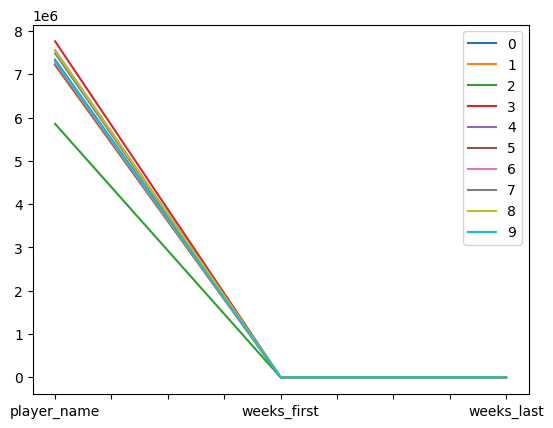

In [63]:
df = get_weeks_first_last(gameweek_totals_df.T)
df.T.plot()